In [1]:
import numpy as np
import pandas as pd

import os

import mdtraj as md
# import pyemma

import matplotlib
import matplotlib.pyplot as plt 
import custom_plots as cp

import importlib
from custom_plots import plot_energized_data, plot_clustered_data, create_custom_cmap, nviridis

In [22]:
import pickle

def save_pickle(out_path, data):
    with open(out_path, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def load_pickle(pickle_path):
    with open(pickle_path, 'rb') as handle:
        return pickle.load(handle)
    
def print_as_latex(MPFT_df):
    """
    Prints the dataframe in Latex format so it can be copied to the SI
    
    """
    
    def format_string(v):
        if v == '-':
            return v
        if float(v) >= 10:
            return f'{v:.0f}'
        else:
            return f'{v:.1f}'
    
    n = (len(MPFT_df))
    print ('\\begin{tabular}{|' + 'l|'*(n+1) +'}')
    print ('\hline')
    print ( ' &', end = ' ')
    for i in range(1, n+1):
        if i == n:
            print (str(i), end = ' ')
        else:
            print (str(i) +' &', end = ' ')
    print ('\\\\\n\hline\hline')
    
    for i, row in MPFT_df.iterrows():
        print (str(i) + ' &', end = ' ')
        l = len(row)
        #print (f'{l=}')
        for k, v in enumerate(np.array(row)):
            if v == 0.0:
                v = '-'
            
            if l == k+1:
                print (format_string(v), end = ' ')
            else:
                print (format_string(v) +' &', end = ' ')
        print ('\\\\')
        print ('\hline')
    print('\end{tabular}')
    print('\end{table}')
    
    
def plot_msm_final2(dihedrals, mtraj, alpha = 1, title = None, colors=None, with_leg=True):
    
    from matplotlib.colors import LinearSegmentedColormap
    
    def add_labels(ax, fontsize):
        ax.set_box_aspect(1)
        ax.set_xlabel(r'$\chi{}_1$ [degrees]', fontsize = fontsize)
        ax.set_ylabel(r'$\chi{}_2$ [degrees]', fontsize = fontsize)

        ax.set_xticks(np.arange(60, 361, 120))
        ax.set_yticks(np.arange(60, 361, 120))

        ax.tick_params(axis="both",direction="in", width = 2, length = 10)
        ax.set_xticklabels(np.arange(60, 361, 120) , fontsize=fontsize)
        ax.set_yticklabels(np.arange(60, 361, 120) , fontsize=fontsize)
        
        # also set limits
        ax.set_ylim([0, 360])
        ax.set_xlim([0, 360])
        
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        
        
    import matplotlib.ticker as ticker

    
    def find_color(x, y):
        """
        finds an appropriate color from the tab20b
        """
        colors = [ 
                '#cedb9c', # light green
                '#e7cb94', # light orange   # FDD5B0   # old one: F99B45
                '#9c9ede', # light blue
                '#637939', # dark green
                '#bd9e39', # dark orange
                '#393b79', # dark blue
                '#7b4173', # dark purple 
                '#de9ed6', # light purple
                '#d6616b', # pink
                ]
        
        
        idx_x = (np.argmin(np.abs([60, 180, 360] - np.average(x))))
        idx_y = (np.argmin(np.abs([60, 180, 360] - np.average(y))))
        
        code = 10*idx_y + idx_x
        mapping = [0, 1, 2, 10, 11, 12, 20, 21, 22]
        return colors[mapping.index(code)]
        
    fontsize = 28
    
    fig = plt.figure(layout="constrained", figsize=(24, 9))
    mosaic = """AB"""
    ax_dict = fig.subplot_mosaic(mosaic)

    ax = ax_dict['A']
    n_states = np.max(mtraj) +1

    levels = np.arange(11)

    # To get the scale includng all 3 of them with proper location of the minima:
    x, y, z = cp.get_histogram(dihedrals[0], dihedrals[1], avoid_zero_count=False, histrange=[[0, 360], [0, 360]])
    f, minim = cp._to_free_energy(z, minener_zero=True) * 1
    #cs = ax.contourf(x, y, f, cmap='Greys_r', alpha=1, levels = levels)
    cs = ax.contourf(x, y, f, cmap=cp.create_custom_cmap('#141414'), alpha=1, levels = levels)
    
    contour = ax.contour(x, y, f, colors='black', alpha=1, levels = levels, linewidths=0.5)
    
    
    # To get coloring right we need to do this step twice:
    offsets = cp.get_offsets(dihedrals, mtraj, n_states, z)
    
    add_labels(ax, fontsize)
    
    cbar = fig.colorbar(cs, shrink = 0.85)
    cbar.ax.set_ylabel('Free Energy / kT', fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize)
    
    contours = []
    
    ax = ax_dict['B']

    # Now plot the actual data
    for i in range(n_states):
        idx = np.where(mtraj == i)
        percent_pop = np.rint(np.count_nonzero(mtraj == i) / len(mtraj) * 100)
        c = find_color(dihedrals[0][idx], dihedrals[1][idx])
        
        # BEFORE WE HAD
        _x, _y, _z = cp.get_histogram(dihedrals[0][idx], dihedrals[1][idx], avoid_zero_count=False, histrange=[[0, 360], [0, 360]])
        _f, _ = cp._to_free_energy(_z, minener_zero=True) * 1

        _f += offsets[i] # gets the right colors for everything (minima is 0 only for lowest macrostate)
        ax.contourf(_x, _y, _f, cmap= LinearSegmentedColormap.from_list('test', [c, c], N=50), 
                    alpha=1, levels = levels)
        contour = ax.contour(_x, _y, _f, colors=c, alpha=1, levels = levels, linewidths=2)
        
        # simple scatter plot
        #ax.scatter(dihedrals[0][idx], dihedrals[1][idx], color=c, s = 10)
        
        #break
        
        if percent_pop == 0:
            ax.scatter(-100, -100, marker = 's', label = f'$S_{i+1}$: < 1%', color = c, s = 144)
        else:
            ax.scatter(-100, -100, marker = 's', label = f'$S_{i+1}$: {percent_pop:.0f}%', color = c, s = 144)
    
    add_labels(ax, fontsize)
    

    
    if title is not None:
        fig.suptitle(title, fontsize = fontsize*1.25)
    


    if with_leg:
        #ax.legend(loc='lower center', fontsize = 0.6* fontsize, ncols = n_states, edgecolor='black')
        legend = ax.legend(loc='center left', fontsize = fontsize, ncols = 1 , edgecolor='black', bbox_to_anchor=(1, 0.5))
        frame = legend.get_frame()
        frame.set_linewidth(2)

    return fig, ax, contours

### Select the isoleucine and FF to chose

In [3]:
ff = 'amber' # or change to 'amber'
ff = 'charmm'


ile = 'ile36' # change to 3, 13, 23, 30, 36, 44, 61

# to select whether we have the minimum number of all states

suffix = 'full'
# suffix = 'minim'

In [4]:
path = os.getcwd()+f'/data/{ff}/{ile}_{suffix}.pkl'
data = load_pickle(path)

In [6]:
data['mfpts_ns']

,1,2,3,4,5,6,7,8,9
1,0.0,99.6,64.6,409.3,505.4,10.7,5.5,4.5,3.6
2,1329.5,0.0,59.6,698.4,790.5,4.4,2.3,6.9,0.4
3,1333.5,98.5,0.0,707.0,799.1,4.7,2.0,7.4,0.2
4,1035.3,94.4,64.1,0.0,101.5,9.8,5.3,9.2,3.3
5,1039.6,94.8,64.4,9.7,0.0,10.1,5.6,9.4,3.6
6,1333.2,97.0,58.4,706.3,798.4,0.0,2.1,7.4,0.2
7,1333.6,100.5,61.3,707.4,799.5,7.7,0.0,7.4,0.1
8,1329.9,102.3,63.9,708.5,800.6,10.2,4.6,0.0,2.7
9,1333.6,100.5,61.3,707.4,799.4,7.7,2.0,7.4,0.0


In [8]:
# print_as_latex(data['mfpts_ns'])

In [28]:
if ff == 'amber':
    ff_label = 'Anmr-def-3P'
else:
    ff_label = 'C36m-def-3P'

ile_nice_name = 'Ile ' + ile[3:]


# The plot style shown in the SI

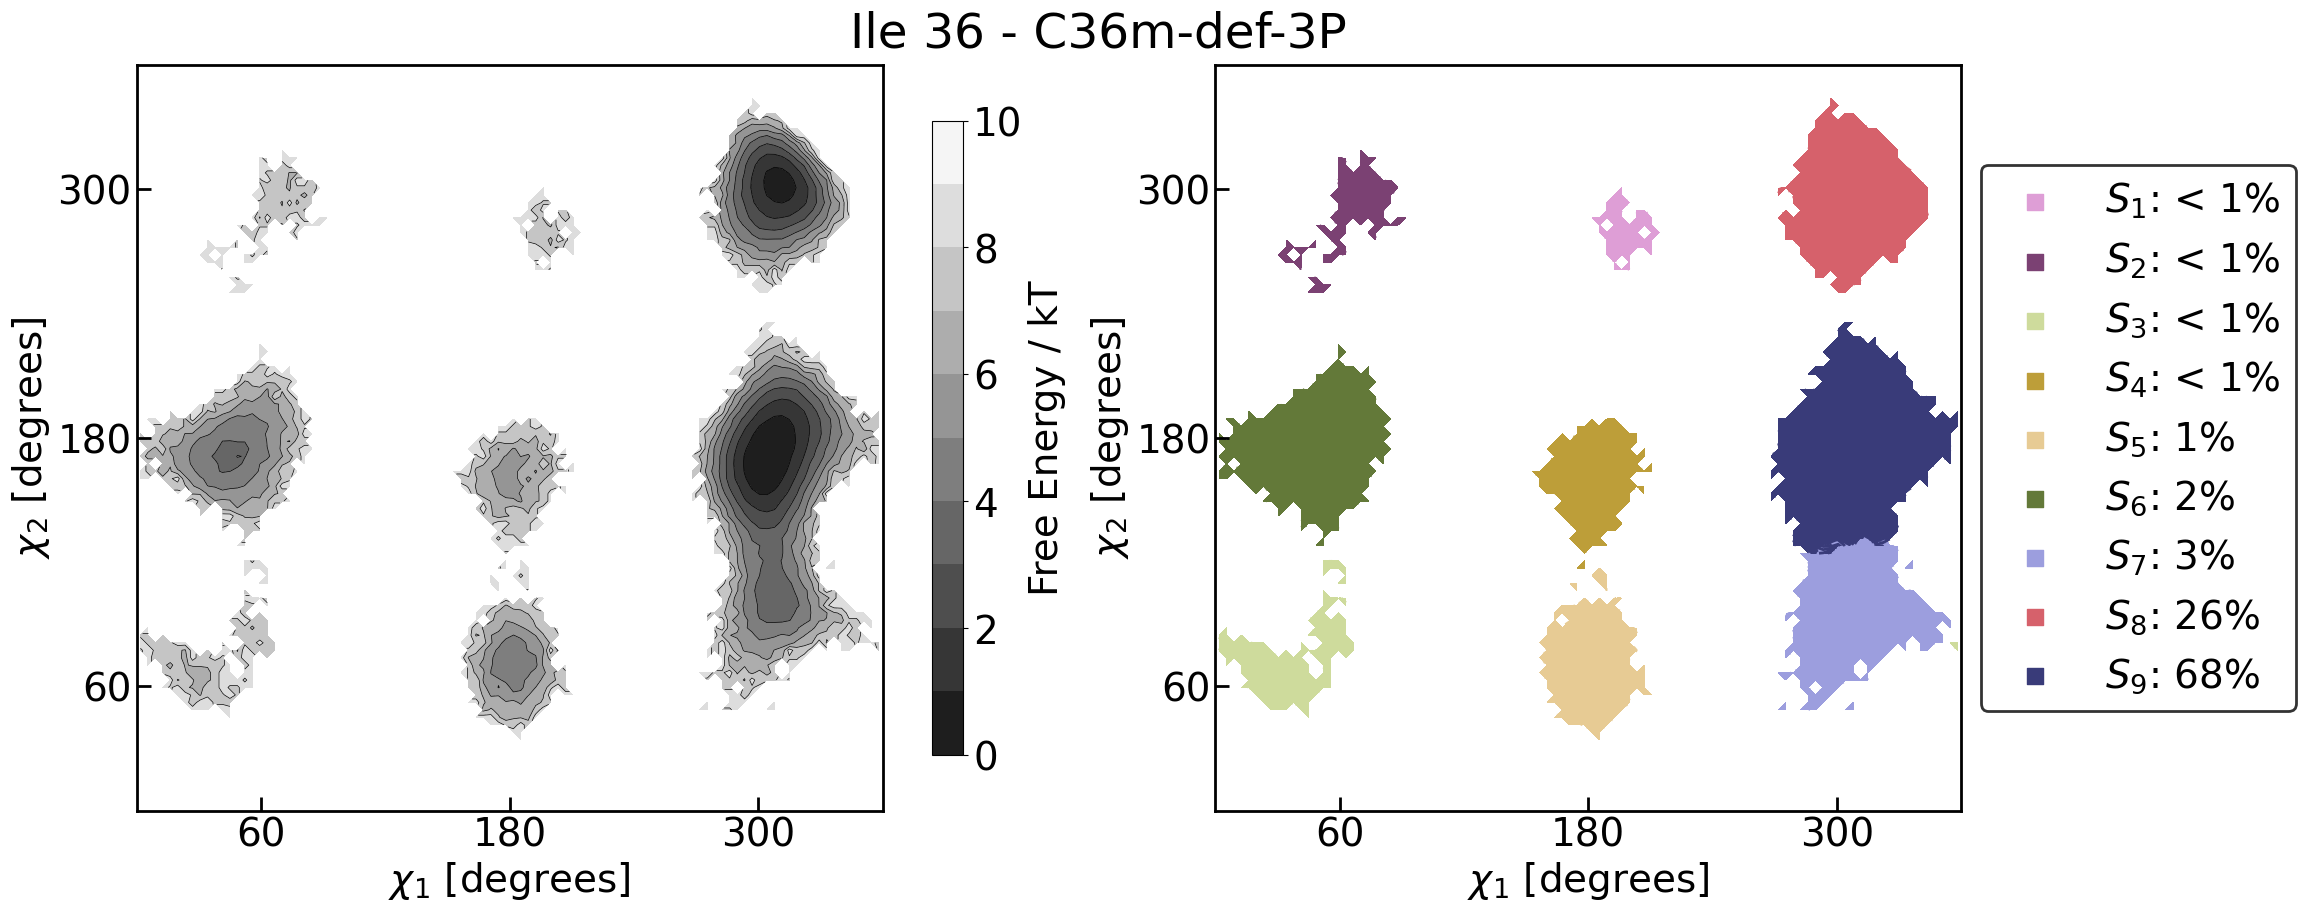

In [29]:

colors = ['#284E60', '#F99B45', '#D95980', '#59CD90', '#946126', 'cornflowerblue', 'purple', 'yellow', 'black']

# reverse colors so the most two populated clusters always have same color
colors = colors[:len(data['mfpts_ns'])][::-1]

fig, ax, contours  = plot_msm_final2(data['dihedrals'], data['metastable_traj'], 
                          alpha = 0.95, title = f'{ile_nice_name} - {ff_label}', colors=colors, 
                          with_leg = True
                         )

# Alternative plot style

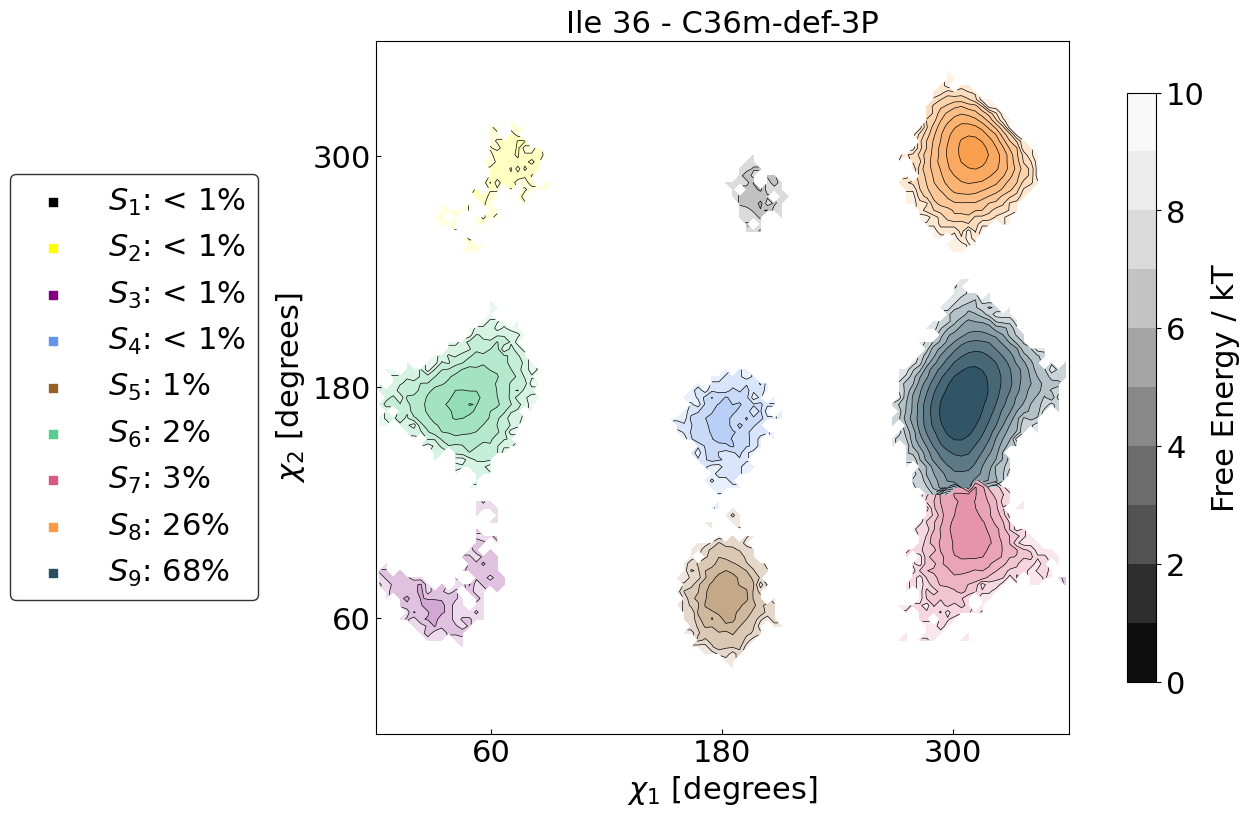

In [30]:

fig, ax, contours  = cp.plot_msm_final(data['dihedrals'], data['metastable_traj'], 
                                       alpha = 0.95, title = f'{ile_nice_name} - {ff_label}', with_leg = True, 
                                       colors = colors
                         )